### NNet Ratio

In [1]:
# import Ratio
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from Ratio import *

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.distributions as dist
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchsummary import summary
import numpy as np
import scipy.stats as scs
from statsmodels.distributions.empirical_distribution import ECDF
import time
import ot
from pyhmc import hmc


c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [2]:
# load airquality dataset
from ucimlrepo import fetch_ucirepo
import numpy as np

# fetch dataset
air_quality = fetch_ucirepo(id=360)
# data (as pandas dataframes)
X = air_quality.data.features.to_numpy()
# only the numeric variables
X = X[:,2:]
# Check the shapes of X and y
print("Shape of X:", X.shape)
X = np.vectorize(pd.to_numeric)(X)

Shape of X: (9357, 13)


In [3]:
MAGIC_data = X + np.random.normal(X.shape[0],X.shape[1])


In [ ]:

# Load the data from the CSV file
MAGIC_data = pd.read_csv('magic.csv')
MAGIC_data = MAGIC_data[MAGIC_data.iloc[:, -1] == 'g']
selected_columns = ['fLength', 'Width', 'fConc', 'fM3Long', 'fM3Trans']
MAGIC_data = np.array(MAGIC_data[selected_columns])

torch.manual_seed(990109)
np.random.seed(990109)

seed = 990109

n_indep = 10

In [33]:

# Load the data from the CSV file
MAGIC_data = pd.read_csv('xcr.csv')
MAGIC_data = MAGIC_data.dropna()
MAGIC_data = np.array(MAGIC_data)
MAGIC_data = MAGIC_data[:,1:]
torch.manual_seed(990109)
np.random.seed(990109)

seed = 990109

n_indep = 10

In [34]:
import numpy as np

# Check if all elements in MAGIC_data are numeric
is_numeric = np.issubdtype(MAGIC_data.dtype, np.number)

if is_numeric:
    print("All elements in MAGIC_data are numeric.")
else:
    print("MAGIC_data contains non-numeric elements.")

All elements in MAGIC_data are numeric.


In [17]:
MAGIC_data.shape

(5842, 5)

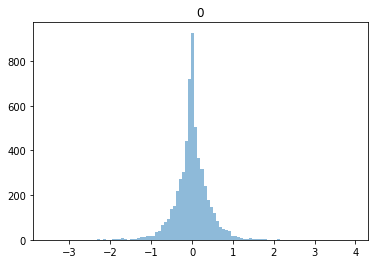

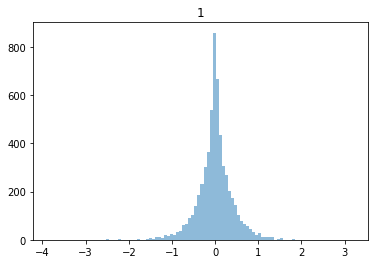

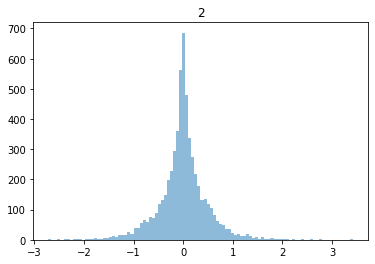

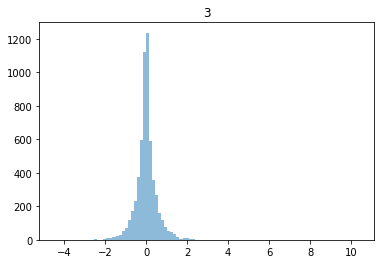

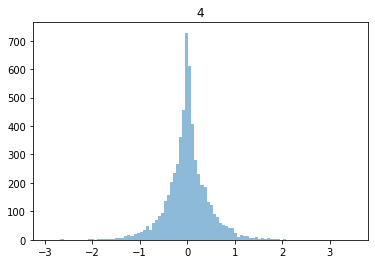

In [35]:
import matplotlib.pyplot as plt
for k in range(len(MAGIC_data[0])):
    plt.hist(MAGIC_data[:,k], bins=100, alpha=0.5)
    plt.title(k)
    plt.show()

In [36]:
# Apply ECDF transformation
X_ecdf = np.zeros_like(MAGIC_data)
ecdf_list = []
for dim in range((MAGIC_data.shape[1])):
    ecdf = ECDF(MAGIC_data[:, dim])
    ecdf_list.append(ecdf)
    X_ecdf[:, dim] = np.clip(ecdf(MAGIC_data[:, dim]), 1e-6, 1 - 1e-6)

# Apply inverse of standard normal CDF (ppf)
X_gaussian = scs.norm.ppf(X_ecdf)
y_gaussian = torch.ones(X_gaussian.shape[0], dtype=torch.long)
# Convert to PyTorch tensors
X_gaussian = torch.tensor(X_gaussian, dtype=torch.float32)
# Split the data into training and testing sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X_gaussian, y_gaussian, test_size=0.5, random_state=seed)
# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)

In [21]:
from tqdm import tqdm

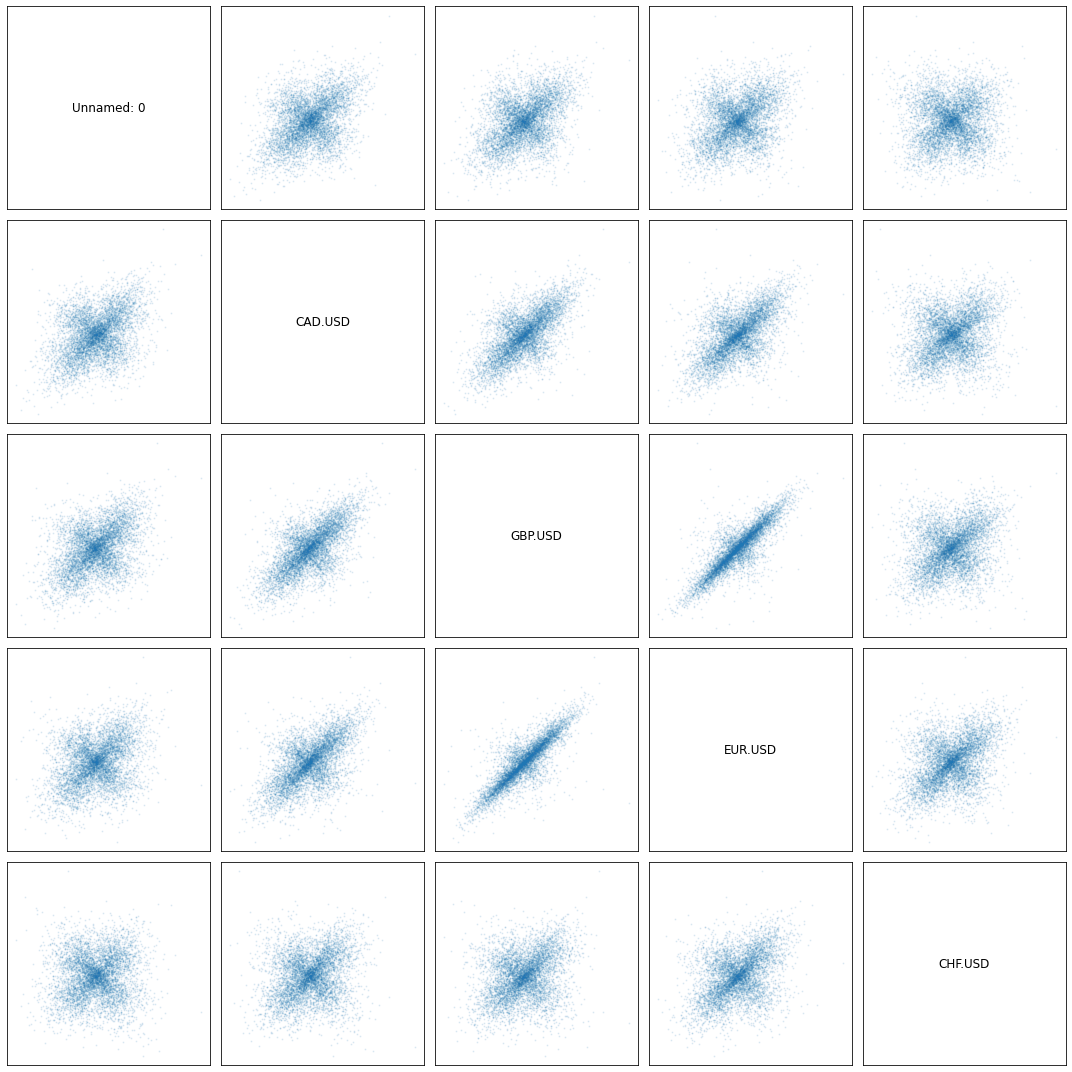

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a 5x5 grid of scatter plots
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for i in range(5):
    for j in range(5):
        if i != j:
            axes[i, j].scatter(X_gaussian[:,i], X_gaussian[:,j], alpha=0.1,s=1)
        else:
            axes[i, j].text(0.5, 0.5, columns[i], ha='center', va='center', fontsize=12)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.tight_layout()
plt.show()

In [76]:
train_ratio_model = True



if train_ratio_model:
    # Define model
    ratio_model = Ratio(h_dim=100, in_dim=MAGIC_data.shape[1], h_layers=2, normalising_cst = True, c = 1.0)

    # training loop for ####  GG Ratio  ####

    # Define loss function and optimizer
    optimizer = torch.optim.Adam(ratio_model.parameters())
    
    n_indep = 30
    num_epochs = 500

    GG_cov = np.cov(X_train.reshape(-1,MAGIC_data.shape[1]).T)

    for epoch in tqdm(range(num_epochs)):
        ratio_model.train()
        running_loss = 0.0
        noise_index = 0 
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            r_p = ratio_model(inputs).squeeze()
            r_q = ratio_model(torch.tensor(scs.multivariate_normal.rvs(mean=np.zeros(MAGIC_data.shape[1]), cov=GG_cov, size=n_indep*inputs.shape[0])).float()).squeeze()
            noise_index += inputs.shape[0]
            loss = loss_nce(r_p, r_q,inputs.shape[0], n_indep*inputs.shape[0])
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, c: {ratio_model.c.item()}")
            # if loss is nan
            if torch.isnan(loss):
                print("Loss is NaN. Exiting training.")
                break

            '''else:# save the model
                filename = f'GGNNet_xcr_.pth'
                torch.save(ratio_model.state_dict(), filename)
            
    
filename = f'GGNNet_xcr_.pth'
ratio_model = Ratio(h_dim=100, in_dim=MAGIC_data.shape[1], h_layers=2, normalising_cst = True, c = 1.0)
ratio_model.load_state_dict(torch.load(filename))'''

ratio_model.eval()


  2%|▏         | 10/500 [00:06<04:43,  1.73it/s]

Epoch 10/500, Loss: 4.101668659845988, c: 0.9811071753501892


  4%|▍         | 20/500 [00:11<03:57,  2.02it/s]

Epoch 20/500, Loss: 3.9250462849934897, c: 0.9753829836845398


  6%|▌         | 30/500 [00:16<03:58,  1.97it/s]

Epoch 30/500, Loss: 3.8521376132965086, c: 0.9729111194610596


  8%|▊         | 40/500 [00:21<03:51,  1.99it/s]

Epoch 40/500, Loss: 3.823738670349121, c: 0.9718196392059326


 10%|█         | 50/500 [00:26<03:41,  2.03it/s]

Epoch 50/500, Loss: 3.79868524869283, c: 0.9704365730285645


 12%|█▏        | 60/500 [00:31<03:19,  2.21it/s]

Epoch 60/500, Loss: 3.7798638025919598, c: 0.9693604111671448


 14%|█▍        | 70/500 [00:36<04:07,  1.74it/s]

Epoch 70/500, Loss: 3.7771577994028727, c: 0.9697360992431641


 16%|█▌        | 80/500 [00:41<03:36,  1.94it/s]

Epoch 80/500, Loss: 3.748455460866292, c: 0.9690864086151123


 18%|█▊        | 90/500 [00:46<03:18,  2.07it/s]

Epoch 90/500, Loss: 3.7490776062011717, c: 0.9695534110069275


 20%|██        | 100/500 [00:51<03:15,  2.05it/s]

Epoch 100/500, Loss: 3.7274768352508545, c: 0.9703584909439087


 22%|██▏       | 110/500 [00:56<03:09,  2.06it/s]

Epoch 110/500, Loss: 3.731099271774292, c: 0.9703656435012817


 24%|██▍       | 120/500 [01:01<03:00,  2.11it/s]

Epoch 120/500, Loss: 3.7297773202260336, c: 0.9710820317268372


 26%|██▌       | 130/500 [01:06<03:30,  1.76it/s]

Epoch 130/500, Loss: 3.7113850116729736, c: 0.9727618098258972


 28%|██▊       | 140/500 [01:12<03:32,  1.70it/s]

Epoch 140/500, Loss: 3.7066105365753175, c: 0.9735179543495178


 30%|███       | 150/500 [01:18<03:25,  1.70it/s]

Epoch 150/500, Loss: 3.707310199737549, c: 0.9744910001754761


 32%|███▏      | 160/500 [01:23<02:44,  2.07it/s]

Epoch 160/500, Loss: 3.6969732284545898, c: 0.9754995703697205


 34%|███▍      | 170/500 [01:28<02:33,  2.15it/s]

Epoch 170/500, Loss: 3.689369964599609, c: 0.9772288203239441


 36%|███▌      | 180/500 [01:32<02:31,  2.12it/s]

Epoch 180/500, Loss: 3.675192864735921, c: 0.977931559085846


 38%|███▊      | 190/500 [01:38<03:06,  1.66it/s]

Epoch 190/500, Loss: 3.6713510831197103, c: 0.9793947339057922


 40%|████      | 200/500 [01:43<02:31,  1.99it/s]

Epoch 200/500, Loss: 3.6594242254892984, c: 0.9804612994194031


 42%|████▏     | 210/500 [01:49<02:20,  2.07it/s]

Epoch 210/500, Loss: 3.6586868445078533, c: 0.9812567830085754


 44%|████▍     | 220/500 [01:53<02:15,  2.06it/s]

Epoch 220/500, Loss: 3.6466328779856365, c: 0.9821893572807312


 46%|████▌     | 230/500 [01:58<02:10,  2.07it/s]

Epoch 230/500, Loss: 3.65943710009257, c: 0.9828625321388245


 48%|████▊     | 240/500 [02:03<02:02,  2.12it/s]

Epoch 240/500, Loss: 3.6455263614654543, c: 0.9837241768836975


 50%|█████     | 250/500 [02:08<02:17,  1.82it/s]

Epoch 250/500, Loss: 3.6327868779500325, c: 0.9851711392402649


 52%|█████▏    | 260/500 [02:14<02:17,  1.75it/s]

Epoch 260/500, Loss: 3.6182019233703615, c: 0.9861847758293152


 54%|█████▍    | 270/500 [02:19<01:50,  2.08it/s]

Epoch 270/500, Loss: 3.6191500345865886, c: 0.987156867980957


 56%|█████▌    | 280/500 [02:23<01:45,  2.09it/s]

Epoch 280/500, Loss: 3.6168659210205076, c: 0.9891958236694336


 58%|█████▊    | 290/500 [02:28<01:42,  2.04it/s]

Epoch 290/500, Loss: 3.59732985496521, c: 0.9904037714004517


 60%|██████    | 300/500 [02:33<01:37,  2.05it/s]

Epoch 300/500, Loss: 3.60610613822937, c: 0.9918428063392639


 62%|██████▏   | 310/500 [02:38<01:30,  2.10it/s]

Epoch 310/500, Loss: 3.5954577763875326, c: 0.9935249090194702


 64%|██████▍   | 320/500 [02:43<01:25,  2.12it/s]

Epoch 320/500, Loss: 3.572372070948283, c: 0.9950461387634277


 66%|██████▌   | 330/500 [02:48<01:24,  2.01it/s]

Epoch 330/500, Loss: 3.599911642074585, c: 0.9958603382110596


 68%|██████▊   | 340/500 [02:53<01:18,  2.04it/s]

Epoch 340/500, Loss: 3.602383772532145, c: 0.9976442456245422


 70%|███████   | 350/500 [02:58<01:12,  2.08it/s]

Epoch 350/500, Loss: 3.557225211461385, c: 0.9994925856590271


 72%|███████▏  | 360/500 [03:03<01:07,  2.09it/s]

Epoch 360/500, Loss: 3.5783253351847333, c: 1.000210165977478


 74%|███████▍  | 370/500 [03:08<01:01,  2.10it/s]

Epoch 370/500, Loss: 3.5534112453460693, c: 1.0023717880249023


 76%|███████▌  | 380/500 [03:12<00:58,  2.04it/s]

Epoch 380/500, Loss: 3.558774741490682, c: 1.003731608390808


 78%|███████▊  | 390/500 [03:17<00:59,  1.84it/s]

Epoch 390/500, Loss: 3.5596995035807293, c: 1.0049833059310913


 80%|████████  | 400/500 [03:22<00:48,  2.08it/s]

Epoch 400/500, Loss: 3.5768561681111652, c: 1.0066245794296265


 82%|████████▏ | 410/500 [03:27<00:42,  2.10it/s]

Epoch 410/500, Loss: 3.5361284255981444, c: 1.0076173543930054


 84%|████████▍ | 420/500 [03:32<00:38,  2.07it/s]

Epoch 420/500, Loss: 3.5524618148803713, c: 1.0086942911148071


 86%|████████▌ | 430/500 [03:37<00:33,  2.07it/s]

Epoch 430/500, Loss: 3.5498910903930665, c: 1.00966477394104


 88%|████████▊ | 440/500 [03:42<00:28,  2.07it/s]

Epoch 440/500, Loss: 3.524904219309489, c: 1.0106346607208252


 90%|█████████ | 450/500 [03:47<00:26,  1.86it/s]

Epoch 450/500, Loss: 3.5117889722188314, c: 1.0120368003845215


 92%|█████████▏| 460/500 [03:52<00:21,  1.90it/s]

Epoch 460/500, Loss: 3.5401779492696126, c: 1.012839913368225


 94%|█████████▍| 470/500 [03:57<00:14,  2.05it/s]

Epoch 470/500, Loss: 3.5101267814636232, c: 1.0140756368637085


 96%|█████████▌| 480/500 [04:02<00:09,  2.09it/s]

Epoch 480/500, Loss: 3.5157145977020265, c: 1.0153268575668335


 98%|█████████▊| 490/500 [04:07<00:04,  2.10it/s]

Epoch 490/500, Loss: 3.497717301050822, c: 1.0165855884552002


100%|██████████| 500/500 [04:12<00:00,  1.98it/s]

Epoch 500/500, Loss: 3.5008336226145427, c: 1.0173851251602173


Ratio(
  (fc_in): Linear(in_features=5, out_features=100, bias=True)
  (fc_hidden): Linear(in_features=100, out_features=100, bias=True)
  (fc_out): Linear(in_features=100, out_features=1, bias=True)
)

In [115]:
filename = f'GGNNet_air_qual_seed_.pth'
ratio_model = Ratio(h_dim=100, in_dim=MAGIC_data.shape[1], h_layers=2, normalising_cst = True, c = 1.0)
ratio_model.load_state_dict(torch.load(filename))

ratio_model.eval()

Ratio(
  (fc_in): Linear(in_features=13, out_features=100, bias=True)
  (fc_hidden): Linear(in_features=100, out_features=100, bias=True)
  (fc_out): Linear(in_features=100, out_features=1, bias=True)
)

In [77]:
# LL computation

ratio_model.eval()
X_train_flat = X_train.reshape(-1, MAGIC_data.shape[1])
X_test_flat = X_test.reshape(-1, MAGIC_data.shape[1])
GG_cov = np.cov(X_train_flat.T)
# Define the multivariate normal distribution with the given covariance matrix
GG_cov_tensor = torch.tensor(GG_cov, dtype=torch.float32)
multivariate_normal = dist.MultivariateNormal(loc=torch.zeros(MAGIC_data.shape[1]), covariance_matrix=GG_cov_tensor)
# Define the standard normal distribution
standard_normal = dist.Normal(loc=0, scale=1)
# Compute logpdf for the multivariate normal distribution
logpdf_multivariate_train = multivariate_normal.log_prob(X_train_flat)
logpdf_multivariate_test = multivariate_normal.log_prob(X_test_flat)
# Compute logpdf for the standard normal distribution and sum over the dimensions
logpdf_standard_train = standard_normal.log_prob(X_train_flat).sum(dim=1)
logpdf_standard_test = standard_normal.log_prob(X_test_flat).sum(dim=1)
# Compute GG_correction
GG_correction_train = logpdf_multivariate_train - logpdf_standard_train
GG_correction_test = logpdf_multivariate_test - logpdf_standard_test
# Compute means
mean_GG_correction_train = GG_correction_train.mean()
mean_GG_correction_test = GG_correction_test.mean()

# Compute GG ratio alone
gg_ratio_train = ratio_model(X_train).log().mean()
gg_ratio_test = ratio_model(X_test).log().mean()

# Compute GG ratio corrected
gg_ratio_corrected_train = (GG_correction_train + ratio_model(X_train).log()).mean()
gg_ratio_corrected_test = (GG_correction_test + ratio_model(X_test).log()).mean()

# Print the results
print('GG ratio alone', gg_ratio_train.item(), gg_ratio_test.item())
print('GG ratio corrected ; GG_ratio full', gg_ratio_corrected_train.item(), gg_ratio_corrected_test.item())

#xcr GG ratio corrected ; GG_ratio full 1.8095532655715942 1.5554563999176025


GG ratio alone 0.992871105670929 0.27171024680137634
GG ratio corrected ; GG_ratio full 2.107337713241577 1.361950159072876


In [78]:
import scipy.stats as scs
# HMC

def sample_GG_hmc(GG_ratio_model, num_samples, num_runs_hmc, num_burnin):
    ''' 
    Sample from the ratio model with HMC.
    
    args:
        GG_ratio_model: nn.Module - the GG ratio copula model
        num_samples: int - the number of samples to generate per HMC run
        num_runs_hmc: int - the number of HMC runs, each giving num_samples draws
        num_burnin: int - the number of burn-in steps for a single HMC run
    
    returns:
        samples,log_pdf with
        samples: np.array - the generated samples of shape (num_runs_hmc*num_samples, 10)
        log_pdf: np.array - the log-pdf of the samples of shape (num_runs_hmc*num_samples,)
    '''
    GG_ratio_model.eval()
    def log_GGratio_gauss(x):
        ''' 
        Compute the log-pdf of the GG_ratio copula model and its gradient at x. 
        Takes the ratio model and adjusts it by the GG factor to make it into a copula.
        '''
        # compute the top part of a GG_ratio copula logpdf and the gradients of that
        x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        x_flat = x_tensor.reshape(-1, MAGIC_data.shape[1])
        # define N(Sigma) and N(0,1), then compute on x
        GG_cov_tensor = torch.tensor(GG_cov, dtype=torch.float32)
        multivariate_normal = dist.MultivariateNormal(loc=torch.zeros(MAGIC_data.shape[1]), covariance_matrix=GG_cov_tensor)
        standard_normal = dist.Normal(loc=0, scale=1)
        logpdf_multivariate = multivariate_normal.log_prob(x_flat)
        #logpdf_standard = standard_normal.log_prob(x_flat).sum(dim=1)
        gg_correction = logpdf_multivariate #- logpdf_standard
        # Compute the log of the ratio model
        log_ratio = torch.log(GG_ratio_model(x_tensor)).sum()
        # Compute the log probability of x under the standard normal distribution
        #log_prob_standard = standard_normal.log_prob(x_tensor).sum()
        # Compute the final function value
        fun = log_ratio + gg_correction #+ log_prob_standard
        # Backward pass to compute the gradient
        fun.backward()
        grad_wrt_x = x_tensor.grad.reshape(1, -1)[0]
        
        return np.array(fun.item(), dtype=np.float64), np.array(grad_wrt_x.detach().numpy(), dtype=np.float64)

    samples = np.zeros((num_runs_hmc, num_samples, MAGIC_data.shape[1]))
    log_pdf = np.zeros((num_runs_hmc, num_samples))
    x0_noise = np.zeros((num_runs_hmc,MAGIC_data.shape[1]))
    for hmc_run in tqdm( range(num_runs_hmc)):

        '''# pick x0 with highest r(x0) from random noise
        x0_proposal = torch.randn(1000, 1, 8, 8)
        r_noise = model(x0_proposal)
        x0_run = x0_proposal[np.argmax(r_noise.detach().numpy().flatten())]    
        '''
        '''# pick x0 randomly from N(0,1) 
        x0_run = torch.randn(1, MAGIC_data.shape[1])'''
        GG_cov = np.cov(X_train.reshape(-1,MAGIC_data.shape[1]).T)
        x0_run_np = scs.multivariate_normal.rvs(mean=np.zeros(MAGIC_data.shape[1]), cov=GG_cov, size=1).reshape(1,MAGIC_data.shape[1])
        x0_run = torch.tensor(x0_run_np, dtype=torch.float32)
        samples_, log_pdf_ = hmc(log_GGratio_gauss,
                            x0=x0_run.flatten().numpy(),
                            n_samples=num_samples,
                            return_logp=True,
                            n_burn=num_burnin)
        
        samples[hmc_run] = samples_
        log_pdf[hmc_run] = log_pdf_
        x0_noise[hmc_run] = x0_run

    return samples.reshape(-1,MAGIC_data.shape[1]), log_pdf.reshape(-1), x0_noise

samples_simpleGG, log_pdf, x0_noises = sample_GG_hmc(GG_ratio_model=ratio_model, 
                            num_samples=1, 
                            num_runs_hmc=500,
                            num_burnin=100)
print(samples_simpleGG.shape)

# Save the samples and log probabilities
#np.save(f'GGNNet_HM100burnin_N01_{n_indep}_{seed}_samples_digits.npy', samples_simpleGG)

100%|██████████| 500/500 [02:48<00:00,  2.97it/s]

(500, 5)


(array([0.00882227, 0.03991026, 0.15628019, 0.34616902, 0.38649939,
        0.20963391, 0.06679718, 0.01176303, 0.00084022, 0.00042011]),
 array([-3.39563465, -2.58072877, -1.76582289, -0.95091701, -0.13601112,
         0.67889476,  1.49380064,  2.30870652,  3.1236124 ,  3.93851829,
         4.75342417]),
 <BarContainer object of 10 artists>)

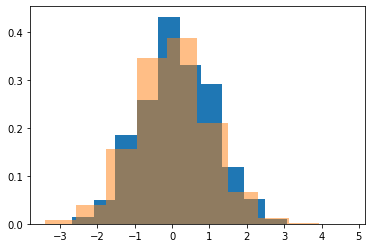

In [81]:
import matplotlib.pyplot as plt
plt.hist(samples_simpleGG[:,0],density=True)
plt.hist(X_train[:,0].numpy(), alpha=0.5, density=True)

In [82]:
# assess sample quality

def W2(x,y):
    return torch.sqrt(ot.emd2(torch.ones(x.shape[0])/x.shape[0], torch.ones(y.shape[0])/y.shape[0], ot.dist(x, y)))

print(W2(X_test.reshape(-1,MAGIC_data.shape[1]).float(),torch.tensor(samples_simpleGG).float()),'GG+Netratio 100hmc') 
print(W2(X_test.reshape(-1,MAGIC_data.shape[1]).float(),X_train.reshape(-1,MAGIC_data.shape[1]).float()[:50]),'true obs')
print(W2(X_test.reshape(-1,MAGIC_data.shape[1]).float(),torch.tensor(scs.multivariate_normal.rvs(mean=np.zeros(MAGIC_data.shape[1]), cov=GG_cov, size=500)).float()[:50]),'gaussian')
print(W2(X_test.reshape(-1,MAGIC_data.shape[1]).float(),torch.randn(500,MAGIC_data.shape[1]).float()[:50]),'random')

print((n_indep,seed,train_ratio_model))

#tensor(3.6378) GG+Netratio 100hmc


tensor(0.8059) GG+Netratio 100hmc
tensor(1.4921) true obs
tensor(1.2285) gaussian
tensor(1.7974) random
(30, 990109, True)


### IGC vine and Gaussian

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.distributions as dist
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchsummary import summary
import numpy as np
import scipy.stats as scs
from statsmodels.distributions.empirical_distribution import ECDF
import time
import ot
from pyhmc import hmc
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as scs
from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
import pyvinecopulib as pv
import pandas as pd


In [41]:
def loss_nce(r_p, r_q,p_size, q_size):
    v = q_size / p_size
    return (-(r_p /(v+r_p)).log()).mean() - v* ((v/(v+r_q)).log().mean()) 

def W2(x,y):
    return torch.sqrt(ot.emd2(torch.ones(x.shape[0])/x.shape[0], torch.ones(y.shape[0])/y.shape[0], ot.dist(x, y)))


In [43]:
U = scs.norm.cdf(X_train.reshape(-1,MAGIC_data.shape[1]))
U_test = scs.norm.cdf(X_test.reshape(-1,MAGIC_data.shape[1]))

In [84]:

class SoftRank(nn.Module):
    """Differentiable ranking layer"""
    def __init__(self, alpha=1000.0):
        super(SoftRank, self).__init__()
        self.alpha = alpha # constant for scaling the sigmoid to approximate sign function, larger values ensure better ranking, overflow is handled properly by PyTorch

    def forward(self, inputs):
        # input is a ?xSxD tensor, we wish to rank the S samples in each dimension per each batch
        # output is  ?xSxD tensor where for each dimension the entries are (rank-0.5)/N_rank
        x = inputs.unsqueeze(-1) #(?,S,D) -> (?,S,D,1)
        x_2 = x.repeat(1, 1, 1, x.shape[1]) # (?,S,D,1) -> (?,S,D,S) (samples are repeated along axis 3, i.e. the last axis)
        x_1 = x_2.transpose(1, 3) #  (?,S,D,S) -> (?,S,D,S) (samples are repeated along axis 1)
        return torch.transpose(torch.sum(torch.sigmoid(self.alpha*(x_1-x_2)), dim=1), 1, 2)/(torch.tensor(x.shape[1], dtype=torch.float32))


class IGC(nn.Module):
    
    def __init__(self, hidden_size=100, layers_number=2, output_size=2):
        super(IGC, self).__init__()
        self.dim_latent = 3 * output_size
        self.hidden_size = hidden_size
        self.layers_nuber = layers_number
        self.output_size = output_size
        self.linear_in = nn.Linear(in_features=self.dim_latent, out_features=self.hidden_size) 
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size)
        self.linear_out = nn.Linear(in_features=self.hidden_size, out_features=self.output_size)
        self.marginal_cdfs = None
        self.ecdf_10e6_samples = None

    def forward_train(self, z):
        '''
        Input noise z with shape (M,dim_latent)\\
        Outputs (u,v) pairs with shape (M,output_size=2), while ensuring u and v each have uniform marginals.
        '''
        y = torch.relu(self.linear_in(z))
        for layer in range(self.layers_nuber):
            y = torch.relu(self.linear(y))
        y = self.linear_out(y).unsqueeze(0)
        u = SoftRank()(y).squeeze(0)
        return u
        
    def Energy_Score_pytorch(self,beta, observations_y, simulations_Y):
        n = len(observations_y)
        m = len(simulations_Y)

        # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
        diff_Y_y = torch.pow(
            torch.norm(
                (observations_y.unsqueeze(1) -
                simulations_Y.unsqueeze(0)).float(),
                dim=2,keepdim=True).reshape(-1,1),
            beta)

        # Second part |Y-Y'|. 2* because pdist counts only once.
        diff_Y_Y = 2 * torch.pow(
            nn.functional.pdist(simulations_Y),
            beta)
        Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
        return Energy


    def forward(self, n_samples):
        ''' 
        Function to sample from the copula, once training is done.

        Input: n_samples - number of samples to generate
        Output: torch.tensor of shape (n_samples, output_size) on copula space.
        '''
        with torch.no_grad():
            if self.marginal_cdfs is None:
                self.marginal_cdfs = []
                # sample 10^6 points from the latent space and compute empirical marginal cdfs
                z = torch.randn(10**6, self.dim_latent)
                y = torch.relu(self.linear_in(z))
                for layer in range(self.layers_nuber):
                    y = torch.relu(self.linear(y))
                y = self.linear_out(y) # samples used to approximate cdfs
                for dim in range(y.shape[1]):
                    ecdf = ECDF(y[:, dim].numpy())
                    self.marginal_cdfs.append(ecdf)
                self.ecdf_10e6_samples = y
            # sample the latent space and apply ecdfs
            z = torch.randn(n_samples, self.dim_latent)
            y = torch.relu(self.linear_in(z))
            for layer in range(self.layers_nuber):
                y = torch.relu(self.linear(y))
            y = self.linear_out(y)
            for dim in range(y.shape[1]):
                y[:, dim] = torch.tensor(self.marginal_cdfs[dim](y[:, dim].numpy()), dtype=torch.float32)
            return y


In [85]:

# make training data on 0-1 scale
X_train_cop = torch.tensor(scs.norm.cdf(X_train.reshape(-1,MAGIC_data.shape[1])),dtype=torch.float32).clip(1e-5,1-1e-5)

# training loop
igc_cop = IGC(hidden_size=100, layers_number=2, output_size=MAGIC_data.shape[1])

u_obs = X_train_cop

optimizer = torch.optim.Adam(igc_cop.parameters())
loss_hist = []

for i in tqdm(range(501)):
    optimizer.zero_grad()
    u = igc_cop.forward_train(torch.randn((200, igc_cop.dim_latent)))
    loss = igc_cop.Energy_Score_pytorch(1, u_obs[np.random.choice(range(u_obs.shape[0]),100,replace=True)], u)
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())

# save the model
torch.save(igc_cop.state_dict(), f'igc_cop{seed}.pth')
# sample
samples_cdf = igc_cop.forward(500).detach().numpy()
# save the samples
#np.save(f'samples_igc{seed}.npy',samples_cdf)
print((W2(X_test.reshape(-1,MAGIC_data.shape[1]).float(),torch.tensor(scs.norm.ppf(samples_cdf)).float(),),'IGC'))


100%|██████████| 501/501 [00:04<00:00, 103.90it/s]


(tensor(0.7901), 'IGC')


In [102]:
samples_cdf = igc_cop.forward(500).detach().numpy()
# save the samples
#np.save(f'samples_igc{seed}.npy',samples_cdf)
print((W2(X_test.reshape(-1,MAGIC_data.shape[1]).float(),torch.tensor(scs.norm.ppf(samples_cdf)).float(),),'IGC'))

(tensor(0.7997), 'IGC')


In [50]:
U.shape

(2921, 5)

In [118]:
U = scs.norm.cdf(X_train.reshape(-1,MAGIC_data.shape[1]))
U_test = scs.norm.cdf(X_test.reshape(-1,MAGIC_data.shape[1]))




start = time.time()
controls = pv.FitControlsVinecop(family_set=[pv.BicopFamily.tll],
                                                selection_criterion='mbic',
                                                nonparametric_method='constant', #KDE-copula
                                                nonparametric_mult=1,
                                                #trunc_lvl=2,
                                                #threshold=0.05, # truntrunc_lvl=5,threshold=0.05 30K mnist -> 33mins train/sample/evals
                                                num_threads = 8) # bandwidth
cop = pv.Vinecop(U, controls=controls)
print('fitted',time.time()-start)

time2 = time.time()
cop_sample = cop.simulate(500)
print('sims', time.time()-time2)

time3 = time.time()
cop_logpdf = cop.loglik(U_test)
print('logpdf', time.time()-time3)
print(bdw,cop_logpdf/U_test.shape[0])
cop_sample_norm = scs.norm.ppf(cop_sample)
print(W2(torch.tensor(X_train.reshape(-1,MAGIC_data.shape[1])).float(),torch.tensor(cop_sample_norm).reshape(-1,MAGIC_data.shape[1]).float()))

fitted 143.10432291030884
sims 0.22054457664489746
logpdf 0.05008578300476074
0.6444444444444445 1.5482845607108082


C:\Users\david\AppData\Local\Temp\ipykernel_28112\3149219282.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(W2(torch.tensor(X_train.reshape(-1,MAGIC_data.shape[1])).float(),torch.tensor(cop_sample_norm).reshape(-1,MAGIC_data.shape[1]).float()))


tensor(0.8294)


In [106]:
cop_sample_norm = scs.norm.ppf(cop_sample)

W2(X_test.reshape(-1,MAGIC_data.shape[1]).float(),torch.tensor(cop_sample_norm).reshape(-1,MAGIC_data.shape[1]).float())

tensor(0.9010)